<a href="https://colab.research.google.com/github/cjbarrie/promptstability/blob/main/notebooks/manisfestos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and Data

In [1]:
! pip install openai
! pip install simpledorff
! pip install torch
! pip install transformers
! pip install sentence_transformers
! pip install SentencePiece


In [2]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import pandas as pd
import openai
import numpy as np
import time
import simpledorff
from openai import OpenAI
import matplotlib.pyplot as plt


import torch
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import os

import simpledorff

from transformers import AutoModelForCausalLM, AutoTokenizer


In [3]:
# count tokens
from transformers import AutoTokenizer

model_count_tokens = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_count_tokens)

def count_tokens(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Return the count of tokens
    return len(tokens)


In [4]:
class LLMWrapper:
    '''This is a wrapper class for LLMs, which provides a method called 'annotate' that annotates a given message using an LLM.
    '''

    def __init__(self,apikey, model, wait_time=0.8) -> None:
        self.apikey = apikey
        self.model = model

        self.client = OpenAI(
            # This is the default and can be omitted
            api_key=apikey
        )


    def annotate(self, text, prompt, parse_function = None, temperature = 0.1):
        '''
        Annotate the given text in the way the prompt instructs you to.

        Parameters:
        - text (str): text you want classified
        - prompt (str): the classification prompt/instruction
        - temperature (float): how deterministic (low number) vs. random (higher number) your results should be
        - parse_function (method): a method that parses the resulting data.

        Returns:
        - model's response to prompt (classification outcome)
        '''
        failed = True
        tries = 0
        while(failed):
            try:
                response = self.client.chat.completions.create(
                    model = self.model,
                    temperature = temperature,
                    messages = [
                        {"role": "system", "content": f"'{prompt}'"}, #The system instruction tells the bot how it is supposed to behave
                        {"role": "user", "content": f"'{text}'"} #This provides the text to be analyzed.
                    ]
                )
                failed = False

            #Handle errors.
            #If the API gets an error, perhaps because it is overwhelmed, we wait 10 seconds and then we try again.
            # We do this 10 times, and then we give up.
            except openai.APIError as e:
                print(f"OpenAI API returned an API Error: {e}")

                if tries < 10:
                    print(f"Caught an APIError: {e}. Waiting 10 seconds and then trying again...")
                    failed = True
                    tries += 1
                    time.sleep(10)
                else:
                    print(f"Caught an APIError: {e}. Too many exceptions. Giving up.")
                    raise e

            except openai.APIConnectionError as e:
                print(f"Failed to connect to OpenAI API: {e}")
                pass
            except openai.RateLimitError as e:
                print(f"OpenAI API request exceeded rate limit: {e}")
                pass

            #If the text is too long, we truncate it and try again. Note that if you get this error, you probably want to chunk your texts.
            except openai.BadRequestError as e:
                #Shorten request text
                print(f"Received a InvalidRequestError. Request likely too long. {e}")
                raise e

            except Exception as e:
                print(f"Caught unhandled error. {e}")
                raise e

        result = ''
        for choice in response.choices:
            result += choice.message.content

        # Parse the result using provided function
        if parse_function is not None:
            result = parse_function(result)

        return result


class PromptStabilityAnalysis:

    def __init__(self,llm, data, metric_fn=simpledorff.metrics.nominal_metric, parse_function=None) -> None:

        self.llm = llm

        # Get a number for the similarity between two sentences
        self.embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

        #Initiate paraphraser
        model_name = 'tuner007/pegasus_paraphrase'
        self.torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = PegasusTokenizer.from_pretrained(model_name)
        self.model = PegasusForConditionalGeneration.from_pretrained(model_name).to(self.torch_device)
        self.parse_function = parse_function  #The function through which to parse the result from the LLM
        self.data = data # The data to be analyzed. Should be a list of texts.
        self.metric_fn = metric_fn #Metric function for KA. e.g., simpledorff.metrics.interval_metric or nominal_metric metric_fn=simpledorff.metrics.nominal_metric

    # Compares similarity between two sentences in sentence embedding space
    def __compare_similarity(self,sent1,sent2):
        emb1 = self.embedding_model.encode(sent1, convert_to_tensor=True)
        emb2 = self.embedding_model.encode(sent2, convert_to_tensor=True)

        return util.pytorch_cos_sim(emb1, emb2)

    # Uses Pegasus to paraphrase a sentence
    def __paraphrase_sentence(self, input_text, num_return_sequences=10, num_beams=10, temperature=1.5):
        batch = self.tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(self.torch_device)
        translated = self.model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=temperature)
        tgt_text = self.tokenizer.batch_decode(translated, skip_special_tokens=True)
        return tgt_text

    #This generates paraphrases based on an original text and uses sentence embedding to measure how different they are from the original sentence.
    #prompt_postfix is a fixed addition that is not paraphrased
    def __generate_paraphrases(self,original_text,prompt_postfix,nr_variations,temperature=1.5):
        # Create paraphrases of sentence
        phrases = self.__paraphrase_sentence(original_text,num_return_sequences=nr_variations,temperature=temperature)

        # Measure distances between new and original
        l = [{'similarity':1.0,'phrase':f'{original_text} {prompt_postfix}','original':True}]
        for phrase in phrases:
            sim = self.__compare_similarity(original_text,phrase)
            l.append({'similarity':float(sim),'phrase':f'{phrase} {prompt_postfix}','original':False})

        # Store for future use
        self.paraphrases = pd.DataFrame(l).sort_values(['similarity'])
        display(self.paraphrases)
        return self.paraphrases

    def baseline_stochasticity(self,original_text,prompt_postfix,iterations=10):
        '''
        This measures the amount of stochasticity there is within the same prompt, running the original prompt <iterations> and
        measuring the KA reliability over runs.
        '''
        prompt = f'{original_text} {prompt_postfix}'
        annotated = []
        # Run the LLM on the data
        for i in range(iterations):
            print(f"Iteration {i}...")
            for j,d in enumerate(self.data):
                annotation = self.llm.annotate(d, prompt,parse_function=self.parse_function)
                annotated.append({'id':j,'text':d,'annotation':annotation,'iteration':i})

        print('Finished annotation. Analyzing reliability')
        df = pd.DataFrame(annotated)

        # Measure the intercoder reliability
        KA = simpledorff.calculate_krippendorffs_alpha_for_df(
            df,
            metric_fn=self.metric_fn,
            experiment_col='id',
            annotator_col='iteration',
            class_col='annotation')
        print(KA)
        return KA,df


    def interprompt_stochasticity(self,original_text,prompt_postfix, nr_variations=5, temperature=1.0, iterations=1):
        '''
        This measures the amount of stochasticity while varying the prompt.
        prompt_postfix: A fixed addition to the prompt. This is not paraphrased. Used to specify output format.
        '''

        # Generate paraphrases
        paraphrases = self.__generate_paraphrases(original_text,prompt_postfix,nr_variations=nr_variations,temperature=temperature)

        annotated = []
        # Run the LLM on the data
        for i, (paraphrase,similarity,original) in enumerate(zip(paraphrases['phrase'],paraphrases['similarity'],paraphrases['original'])):
            print(f"Iteration {i}...")
            for j,d in enumerate(self.data):
                annotation = self.llm.annotate(d, paraphrase,parse_function=self.parse_function)
                annotated.append({'id':j,'text':d,'annotation':annotation,'prompt_id':i,'prompt':paraphrase,'similarity':similarity,'original':original})

        print('Finished annotation. Analyzing reliability')
        annotated_data = pd.DataFrame(annotated)

        self.interprompt_df = annotated_data

        # Measure the interprompt reliability
        KA = simpledorff.calculate_krippendorffs_alpha_for_df(annotated_data,metric_fn=self.metric_fn,experiment_col='id', annotator_col='prompt_id', class_col='annotation')
        print(f'The resulting interprompt KA reliability value is {KA}')

        rel_vs_sim = self.__calculate_reliability_as_function_of_similarity(annotated_data)

        plt.scatter(rel_vs_sim['similarity'], rel_vs_sim['KA'])
        plt.xlabel('Similarity')
        plt.ylabel('Reliability')
        plt.title('Reliability vs similarity')
        plt.show()

        return KA,annotated_data,rel_vs_sim


    #This calculates the KA-R as a function of the similarity between the prompts
    # Takes the output of the interprompt_stochasticity calculation
    def __calculate_reliability_as_function_of_similarity(self,df=None):
        if df is None:
            df = self.interprompt_df

        l = []
        # This calculates the KA separately one-on-one between the prompts, and then uses the similarity between the prompts to say something.
        for prompt_id in df['prompt_id'].loc[df['original']==False].unique():
            # Go through them one at the time
            dff = df.loc[(df['prompt_id']==prompt_id) | (df['original']==True)]
            ka = simpledorff.calculate_krippendorffs_alpha_for_df(dff,metric_fn=self.metric_fn,experiment_col='id', annotator_col='prompt_id', class_col='annotation')

            # Get the similarity of the prompt. Ugly code.
            similarity = df.loc[df['prompt_id']==prompt_id]['similarity'].values[0]
            l.append({'prompt_id':prompt_id,'KA':ka,'similarity':similarity})

        return pd.DataFrame(l)


In [9]:
# Test of wrapper class
llm.annotate(text='A small pet that says miaow and has a great self-esteem.', prompt='Does the message describe a cat or a dog? Repond 0 for cat, and 1 for dog.')#


'0'

In [8]:
# Example use
APIKEY = os.getenv("OPENAI_API_KEY")
MODEL = 'gpt-3.5-turbo'
llm = LLMWrapper(model = MODEL, apikey=APIKEY)

data = ["This creature, often seen as a symbol of independence, gracefully navigates its environment, its eyes shining like beacons in the twilight, always landing on its feet after a calculated leap.",
"With a loyalty as steadfast as the north star, this companion greets each day with boundless enthusiasm, its wagging tail a metronome of joy as it awaits the next adventure beside its human.",
"Cloaked in fur as soft as whispers, this enigmatic being prowls the silent corridors of its domain by night, its silhouette a fleeting ghost against the moonlit windows.",
"An epitome of devotion, this guardian's bark is both a welcoming fanfare and a stern warning, its ears perpetually tuned to the sounds of its family's voices, standing watch over its home with unwavering vigilance.",
"This solitary hunter, with whiskers tuned to the slightest rustle, moves like a shadow through the underbrush, its green gaze piercing the darkness, ever in pursuit of the elusive dance of light and shadow.",
"Bearing a heart as wide as the open field it romps through, this creature's howls weave tales of ancestral wolves, yet its gentle eyes betray a soul purely devoted to the companionship of those it calls its pack.",
"As if adorned with the softest down, this silent watcher claims the highest vantage points as its throne, surveying its kingdom with a regal indifference, yet secretly reveling in the warmth of a gentle stroke.",
"In its eyes, one can see the flicker of ancient fireside companions, its presence a comforting weight at the foot of the bed, a protector of dreams and a keeper of secrets, sharing silent conversations in the stillness of night.",
"With agility that belies its delicate form, this creature commands the air itself, its movements a ballet of precision and grace, leaving only the faintest whispers in its wake as it explores realms both high and low.",
"This jovial spirit, with fur muddied from joyful romps in the rain, returns home with a trophy branch larger than itself, a testament to its undying zest for life and the simple pleasures found in a stick well-chased."]

prompt = 'Does the message describe a cat or a dog?'
prompt_postfix = '[Respond 0 for cat, and 1 for dog.]'
psa = PromptStabilityAnalysis(llm, data)

# Test variability for the same prompt.
res,df = psa.baseline_stochasticity(prompt,prompt_postfix,iterations=3)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration 0...
Iteration 1...
Iteration 2...
Finished annotation. Analyzing reliability
1.0


,similarity,phrase,original
5,0.899961,Is the message about a dog or cat? [Respond 0 ...,False
3,0.917287,Is the message about a cat or a dog? [Respond ...,False
1,0.920899,Is the message about a cat or dog? [Respond 0 ...,False
2,0.937727,Does the message mention a cat or dog? [Respon...,False
4,0.948534,Does the message refer to a cat or dog? [Respo...,False
0,1.000000,Does the message describe a cat or a dog? [Res...,True


Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Finished annotation. Analyzing reliability
The resulting interprompt KA reliability value is 0.6328888888888888


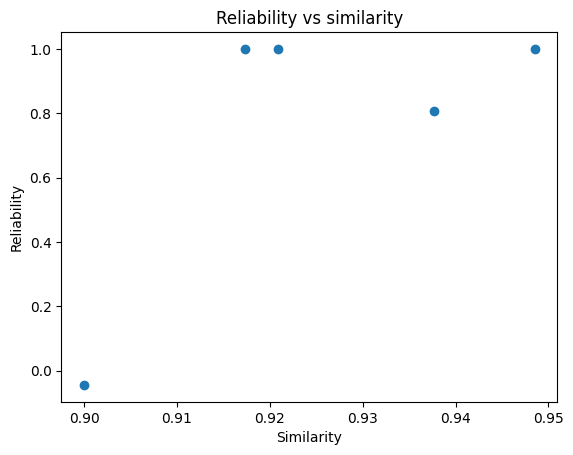

In [ ]:
# Test of variability across prompts
res,df,rel_by_sim = psa.interprompt_stochasticity(prompt,prompt_postfix, nr_variations=5, temperature=1.0, iterations=1)


In [12]:
# Party manifesto example
#APIKEY = "[KEY]"
MODEL = 'gpt-3.5-turbo'
llm = LLMWrapper(model = MODEL, apikey=APIKEY)

# Initialize the model and tokenizer (hugging face model identifier)
try:
    # Try initializing the model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(MODEL)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    MAX_TOKENS = tokenizer.model_max_length
except OSError:
    # If the model identifier is not valid, set MAX_TOKENS to 16385
    MAX_TOKENS = 16385

# Data (upload promptstability/data/UK_Manifestos.csv)
df = pd.read_csv('UK_Manifestos.csv')
df_small = df.iloc[[41, 44]]

# Truncate
texts = [text[:MAX_TOKENS] for text in df_small['content'].values]

prompt = 'The text provided is a party manifesto for a political party in the United Kingdom. Your task is to evaluate evaluate where it is on the scale from left-wing to right-wing on economic issues. Thank you!'
prompt_postfix = '[Respond with a number from 1 to 10. 1 corresponds to most left-wing. 10 corresponds to most right-wing. Your answer should only consist of this number and nothing else.]'

psa = PromptStabilityAnalysis(llm, texts,parse_function=lambda x: float(x), metric_fn = simpledorff.metrics.interval_metric)

# Test variability for the same prompt.
res,df = psa.baseline_stochasticity(prompt,prompt_postfix,iterations=3)
print(df)
# TEAM: Why is there only one KA returned here? does it calculate the average of the two KAs?
# TEAM; Add another graph here, KA by increasing number of repetitions (check Reiss paper). if it doesnt vary a lot, no worries
print(f"The KA reliability for repeating the prompt is {res}")

# Test of variability across prompts
#res,df,rel_by_sim = psa.interprompt_stochasticity(prompt,prompt_postfix, nr_variations=5, temperature=1.0, iterations=1)

#print(f"The KA inter reliability for varying the prompt is {res}")


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration 0...
Iteration 1...
Iteration 2...
Finished annotation. Analyzing reliability
1.0
   id                                               text  annotation  \
0   0  Foreward  Here you can read Labour's plan to d...         2.0   
1   1  new Labour because Britain deserves better Bri...         5.0   
2   0  Foreward  Here you can read Labour's plan to d...         2.0   
3   1  new Labour because Britain deserves better Bri...         5.0   
4   0  Foreward  Here you can read Labour's plan to d...         2.0   
5   1  new Labour because Britain deserves better Bri...         5.0   

   iteration  
0          0  
1          0  
2          1  
3          1  
4          2  
5          2  
The KA reliability for repeating the prompt is 1.0


## test 

In [27]:
class TestTest:

    def __init__(self,llm, data, metric_fn=simpledorff.metrics.nominal_metric, parse_function=None) -> None:

        self.llm = llm

        # Get a number for the similarity between two sentences
        self.embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

        #Initiate paraphraser
        model_name = 'tuner007/pegasus_paraphrase'
        self.torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = PegasusTokenizer.from_pretrained(model_name)
        self.model = PegasusForConditionalGeneration.from_pretrained(model_name).to(self.torch_device)
        self.parse_function = parse_function  #The function through which to parse the result from the LLM
        self.data = data # The data to be analyzed. Should be a list of texts.
        self.metric_fn = metric_fn #Metric function for KA. e.g., simpledorff.metrics.interval_metric or nominal_metric metric_fn=simpledorff.metrics.nominal_metric

    def baseline_stochasticity(self,original_text,prompt_postfix,iterations=10):
        '''
        This measures the amount of stochasticity there is within the same prompt, running the original prompt <iterations> and
        measuring the KA reliability over runs.
        '''
        prompt = f'{original_text} {prompt_postfix}'
        annotated = []
        ka_scores = []
        iterration_no = []

        # Run the LLM on the data
        for i in range(iterations):
            print(f"Iteration {i}...")
            for j,d in enumerate(self.data):
                annotation = self.llm.annotate(d, prompt,parse_function=self.parse_function)
                annotated.append({'id':j,'text':d,'annotation':annotation,'iteration':i})

            # Measure the intercoder reliability (after second iteration)
            if i > 0:
                df = pd.DataFrame(annotated)
                KA = simpledorff.calculate_krippendorffs_alpha_for_df(
                    df,
                    metric_fn=self.metric_fn,
                    experiment_col='id',
                    annotator_col='iteration',
                    class_col='annotation')

                ka_scores.append(KA)
                iterration_no.append(i)

        print('Finished annotation. Analyzing reliability')

        print(f'KA score for repeating the prompt {i} times is {KA}')

        # plot
        plt.scatter(iterration_no, ka_scores)
        plt.xlabel('Repetitions')
        plt.ylabel('KA Score')
        plt.title('Reliability (KA) vs. Repetitions')
        plt.show()

        return KA,df, ka_scores, iterration_no


In [28]:
MODEL = 'gpt-3.5-turbo'
llm = LLMWrapper(model = MODEL, apikey=APIKEY)


In [29]:
tt = TestTest(llm, texts, parse_function=lambda x: float(x), metric_fn = simpledorff.metrics.interval_metric)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Iteration 13...
Iteration 14...
Iteration 15...
Iteration 16...
Iteration 17...
Iteration 18...
Iteration 19...
Finished annotation. Analyzing reliability
KA score for repeating the prompt 19 times is 0.9651439920556107


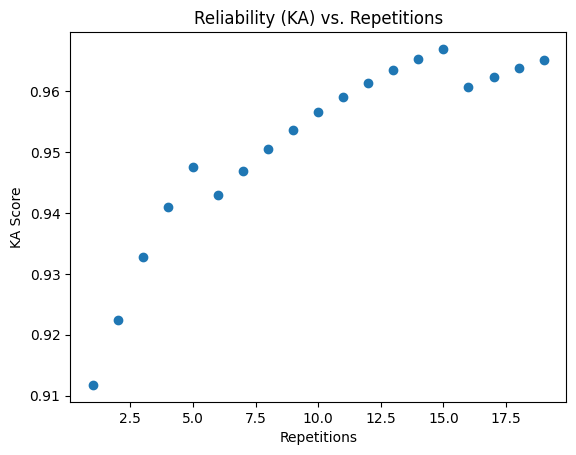

(0.9651439920556107,
     id                                               text  annotation  \
 0    0  Foreward  Here you can read Labour's plan to d...         1.0   
 1    1  new Labour because Britain deserves better Bri...         5.0   
 2    0  Foreward  Here you can read Labour's plan to d...         2.0   
 3    1  new Labour because Britain deserves better Bri...         6.0   
 4    0  Foreward  Here you can read Labour's plan to d...         2.0   
 5    1  new Labour because Britain deserves better Bri...         5.0   
 6    0  Foreward  Here you can read Labour's plan to d...         2.0   
 7    1  new Labour because Britain deserves better Bri...         5.0   
 8    0  Foreward  Here you can read Labour's plan to d...         2.0   
 9    1  new Labour because Britain deserves better Bri...         5.0   
 10   0  Foreward  Here you can read Labour's plan to d...         2.0   
 11   1  new Labour because Britain deserves better Bri...         5.0   
 12   0  Foreward

In [31]:
tt.baseline_stochasticity(prompt,prompt_postfix,iterations=20)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration 0...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Iteration 1...
Iteration 2...
Finished annotation. Analyzing reliability
1.0
    id                                               text  annotation  \
0    0  My bipartisan bill w/ @SenBrianSchatz, the 202...         0.0   
1    1  The Senate Republican COVID package is insulti...         0.0   
2    2  Pres. Trump’s inexplicable deference to Putin ...         0.0   
3    3  It's an exciting day in Tulsa! Be sure to tune...         1.0   
4    4  In our nation’s capital, mass protests are all...         1.0   
5    5  Today we honor the selflessness of the first r...         0.0   
6    6  Between the anguished cries of parents who hav...         0.0   
7    7  Great news: #NorthDakota IPP will transition t...         1.0   
8    8  This is a lifetime appointment for a job that ...         0.0   
9    9  Thank you to @rootinsuranceco for stepping up ...         1.0   
10   0  My bipartisan bill w/ @SenBrianSchatz, the 202...         0.0   
11   1  The Senate Republican COVID package is 

,similarity,phrase,original
3,0.677734,You have to guess if the author is a Republica...,False
4,0.678530,You have to guess if the author is a Republica...,False
1,0.684385,You have to guess whether the author is a Repu...,False
2,0.686123,You have to guess whether the author is a Repu...,False
5,0.743931,The following is a message written by either a...,False
0,1.000000,The following is a Twitter message written eit...,True


Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Finished annotation. Analyzing reliability
The resulting interprompt KA reliability value is 0.9343715239154616


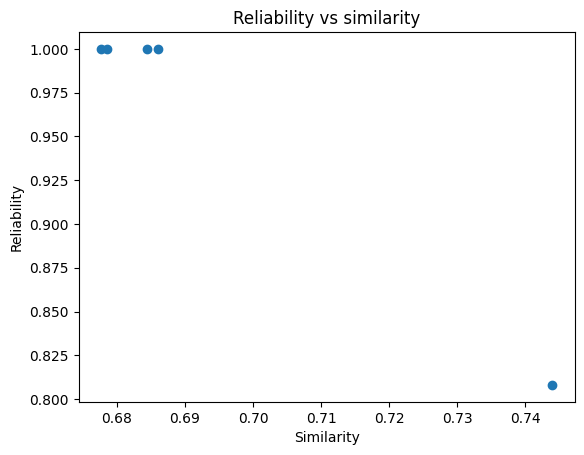

The KA inter reliability for varying the prompt is 0.9343715239154616


In [ ]:
# Twitter annotation example
#APIKEY = "[KEY]"
MODEL = 'gpt-3.5-turbo'
llm = LLMWrapper(model = MODEL, apikey=APIKEY)

MAX_TOKENS = 4096

df = pd.read_csv('tweets.csv')
df = df.sample(10)

# Truncate etc
texts = list(df['text'].values)

prompt = 'The following is a Twitter message written either by a Republican or a Democrat before the 2020 election. Your task is to guess whether the author is Republican or Democrat.'
prompt_postfix = '[Respond 0 for Democrat, or 1 for Republican. Guess is you do not know. Respond nothing else.]'

psa = PromptStabilityAnalysis(llm, texts,parse_function=lambda x: float(x), metric_fn = simpledorff.metrics.nominal_metric)

# Test variability for the same prompt.
res,df = psa.baseline_stochasticity(prompt,prompt_postfix,iterations=3)
print(df)
print(f"The KA reliability for the main message is {res}")

# Test of variability across prompts
res,df,rel_by_sim = psa.interprompt_stochasticity(prompt,prompt_postfix, nr_variations=5, temperature=1.0, iterations=1)

print(f"The KA inter reliability for varying the prompt is {res}")
